# Crop Monitoring 

The objective of this use case is to monitor agricultural fields using a workflow that integrates user's code and EO4EU APIs (SAM and Sentinel-2 APIs).

## Field NDVI Maps

1- Create an ROI that contains the fields of interest using QGIS in EPSG 4326. This ROI will be used to download images from the Sentinel-2 API.

2- Segment the ROI to detect the boundaries of these fields using SAM API.

3- Polygonize the returned results to obtain a polygon per field.

4- Filter small fields using area.

5- Remove polygons of urban areas using QGIS.

6- Obtain the NDVI for each field for a full year from the Sentinel-2 API.

## Leaf Area Index for a Whole Sentinel-2 Tile

1- Prepare a Sentinel-2 band stack for a tile using the Sentinel2 API.

2- Send a requests with the S3 location of the image to estimate LAI for a full tile.

#### If you are running the notebook on Pangeo jupyterlab, run the following cell to install some additional python libraries

In [16]:
! pip3 install folium==0.17.0


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


### Required imports

In [8]:
import os
import requests
import json
import tifffile as tiff
import geopandas as gpd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import folium
from utils import geometry_to_coords,get_filename_from_url,save_image_from_url,raster_to_shapefile
plt.ion()

### URLs of the APIs to be used

In [2]:
sentinel_api = "http://sentinel-api-test.dev.apps.eo4eu.eu"
lai_api = "http://lai-api-test.dev.apps.eo4eu.eu"
sam_api = "http://sam-api-test.dev.apps.eo4eu.eu"

### Headers for the API requests

In [3]:
headers = {
    'accept': 'application/json',
    'access-token': 'YOUR API KEY',
    'Content-Type': 'application/json'
}

### Data directory

In [4]:
data_path = "data/crop_monitoring"
os.makedirs(data_path,exist_ok=True)

### WORKFLOW1 Field NDVI Maps

#### Create a shapefile on QGIS to define the ROI in EPSG 4326. Then read this file and convert the geomerty to xy coordinates to prepare for the API call

In [5]:
roi_gdf = gpd.read_file("data/crop_monitoring/ROI/roi_fields.shp")
geometry = roi_gdf.geometry.iloc[0]
coords = geometry_to_coords(geometry)
coords

[[2.5413447239224496, 48.24090398712013],
 [2.5413447239224496, 48.272903987120124],
 [2.5893447239224496, 48.272903987120124],
 [2.5893447239224496, 48.24090398712013],
 [2.5413447239224496, 48.24090398712013]]

In [40]:
coords_lat_lon = [[lat, lon] for lon, lat in coords]
center_lat = sum(lat for lat, lon in coords_lat_lon) / len(coords_lat_lon)
center_lon = sum(lon for lat, lon in coords_lat_lon) / len(coords_lat_lon)
m = folium.Map(location=[center_lat, center_lon], zoom_start=13)
folium.TileLayer('openstreetmap').add_to(m)
folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(m)
folium.Polygon(
    locations=coords_lat_lon,
    color='blue',
    fill=True,
    fill_color='blue',
    fill_opacity=0.2
).add_to(m)
folium.LayerControl().add_to(m)
m

#### Call the Sentinel API to get RGB images of the ROI. The required parameters are:
- Geometry
- Start date
- End date
- Cloud cover
- Index

In [17]:
data = {
    "geometry":coords,
    "start_date":"2023-06-01",
    "end_date":"2023-09-01",
    "cloud_cover":"10",
    "index":"RGB"  
}
response = requests.post(os.path.join(sentinel_api,"api/v1/s2l2a/roi/process"), headers=headers, json=data)
print(response.text)
task_id = json.loads(response.content.decode())

{"task_id":"97c532b7-b846-4793-b2ff-cab4cdcc79bc"}


#### Monitor task status

In [22]:
params = {'task_id': task_id["task_id"]}
response = requests.get(os.path.join(sentinel_api,"api/v1/task/status"), headers=headers, params=params)
print(response.text)

{"task_id":"97c532b7-b846-4793-b2ff-cab4cdcc79bc","state":"SUCCESS","result":"[{'image': 'L2/tiles/31/U/DP/S2A_MSIL2A_20230614T105031_N0509_R051_T31UDP_20230614T163601.SAFE', 'processed': True, 'url': 'https://object-store.os-api.cci1.ecmwf.int/MoBucket/97c532b7-b846-4793-b2ff-cab4cdcc79bc/T31UDP_20230614T105031_RGB.tif?AWSAccessKeyId=e850aff0dd5749a0a8df9f909014049c&Signature=SGBQ8G8rUvRrd44t659WQIwEMW4%3D&Expires=1719428400', 'uri': 's3://MoBucket/97c532b7-b846-4793-b2ff-cab4cdcc79bc/T31UDP_20230614T105031_RGB.tif'}]"}


#### Get results using task ID

In [23]:
params = {'task_id': task_id["task_id"]}
response = requests.get(os.path.join(sentinel_api,"api/v1/s2l2a/roi/process"), headers=headers, params=params)
results = response.json()
print (results)

{'results': [{'image': 'L2/tiles/31/U/DP/S2A_MSIL2A_20230614T105031_N0509_R051_T31UDP_20230614T163601.SAFE', 'processed': True, 'url': 'https://object-store.os-api.cci1.ecmwf.int/MoBucket/97c532b7-b846-4793-b2ff-cab4cdcc79bc/T31UDP_20230614T105031_RGB.tif?AWSAccessKeyId=e850aff0dd5749a0a8df9f909014049c&Signature=SGBQ8G8rUvRrd44t659WQIwEMW4%3D&Expires=1719428400', 'uri': 's3://MoBucket/97c532b7-b846-4793-b2ff-cab4cdcc79bc/T31UDP_20230614T105031_RGB.tif'}]}


#### Save results from signed URL to local files

In [24]:
rgb_output_path = os.path.join(data_path,"rgb_images")
os.makedirs(rgb_output_path,exist_ok=True)

In [25]:
list_downloaded_imgs = []
for res in results["results"]:
    file_name = get_filename_from_url(res["url"])
    output_file_path = os.path.join(rgb_output_path,file_name)
    save_image_from_url(res["url"],output_file_path)
    list_downloaded_imgs.append(output_file_path)

Image successfully saved to data/crop_monitoring/rgb_images/T31UDP_20230614T105031_RGB.tif


#### Visualize results

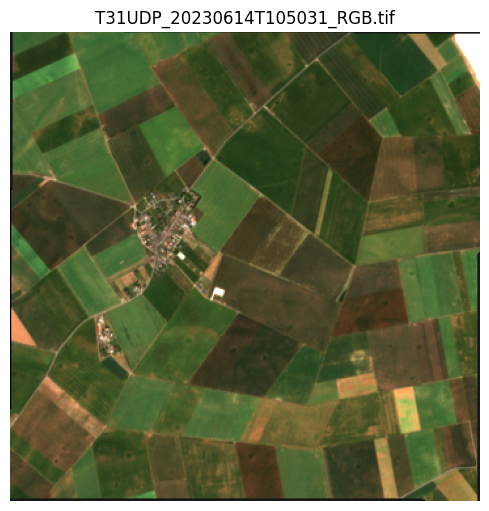

In [26]:
num_images = len(list_downloaded_imgs)
cols = 3  
rows = (num_images // cols) + (num_images % cols > 0) 
plt.figure(figsize=(15, 5 * rows)) 
for i, image_path in enumerate(list_downloaded_imgs):
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        continue
    img = tiff.imread(image_path)
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img.astype("uint8"))
    plt.axis('off') 
    plt.title(os.path.basename(image_path))
plt.tight_layout()
plt.show()

#### Segment the obtained image using automatic SAM segmentation mode. The required parameters are 
```python
{
  "list_images": [
    {
      "image_name": str,
      "image_uri": str,
      "stability_score": float,
      "pred_iou_thresh": float
    }
  ]
}
```

In [27]:
rgb_img_uri = results["results"][0]["uri"]
data ={
  "list_images": [
    {
      "image_name": os.path.basename(rgb_img_uri),
      "image_uri": rgb_img_uri,
      "stability_score": 0.85,
      "pred_iou_thresh": 0.85
    }
  ]
}
response = requests.post(os.path.join(sam_api,"api/v1/automatic"),headers=headers,json=data)
print (response.text)
task_id = json.loads(response.content.decode())

{"task_id":"e73545b8-2212-49be-b73a-7ac4499d635d"}


#### Monitor task status

In [28]:
params = {'task_id': task_id["task_id"]}
response = requests.get(os.path.join(sam_api,"api/v1/task/status"), headers=headers, params=params)
print(response.text)

{"task_id":"e73545b8-2212-49be-b73a-7ac4499d635d","state":"SUCCESS","result":"[{'image_uri': 's3://MoBucket/97c532b7-b846-4793-b2ff-cab4cdcc79bc/T31UDP_20230614T105031_RGB.tif', 'processed': True, 'png_result_url': 'https://object-store.os-api.cci1.ecmwf.int/MoBucket/e73545b8-2212-49be-b73a-7ac4499d635d/T31UDP_20230614T105031_RGB_automatic_mask.png?AWSAccessKeyId=e850aff0dd5749a0a8df9f909014049c&Signature=Mp4xMb9uCrpyAKi2gvsfgtlJfx8%3D&Expires=1719428665', 'png_result_uri': 's3://MoBucket/e73545b8-2212-49be-b73a-7ac4499d635d/T31UDP_20230614T105031_RGB_automatic_mask.png', 'tif_result_url': 'https://object-store.os-api.cci1.ecmwf.int/MoBucket/e73545b8-2212-49be-b73a-7ac4499d635d/T31UDP_20230614T105031_RGB_automatic_mask.tif?AWSAccessKeyId=e850aff0dd5749a0a8df9f909014049c&Signature=8%2FUIYjXFKerLQfXS4TNPe0RIR2w%3D&Expires=1719428665', 'tif_result_uri': 's3://MoBucket/e73545b8-2212-49be-b73a-7ac4499d635d/T31UDP_20230614T105031_RGB_automatic_mask.tif'}]"}


#### Get results using task ID

In [29]:
params = {'task_id': task_id["task_id"]}
response = requests.get(os.path.join(sam_api,"api/v1/prompt"), headers=headers, params=params)
results = response.json()
print (results)

{'results': [{'image_uri': 's3://MoBucket/97c532b7-b846-4793-b2ff-cab4cdcc79bc/T31UDP_20230614T105031_RGB.tif', 'processed': True, 'png_result_url': 'https://object-store.os-api.cci1.ecmwf.int/MoBucket/e73545b8-2212-49be-b73a-7ac4499d635d/T31UDP_20230614T105031_RGB_automatic_mask.png?AWSAccessKeyId=e850aff0dd5749a0a8df9f909014049c&Signature=Mp4xMb9uCrpyAKi2gvsfgtlJfx8%3D&Expires=1719428665', 'png_result_uri': 's3://MoBucket/e73545b8-2212-49be-b73a-7ac4499d635d/T31UDP_20230614T105031_RGB_automatic_mask.png', 'tif_result_url': 'https://object-store.os-api.cci1.ecmwf.int/MoBucket/e73545b8-2212-49be-b73a-7ac4499d635d/T31UDP_20230614T105031_RGB_automatic_mask.tif?AWSAccessKeyId=e850aff0dd5749a0a8df9f909014049c&Signature=8%2FUIYjXFKerLQfXS4TNPe0RIR2w%3D&Expires=1719428665', 'tif_result_uri': 's3://MoBucket/e73545b8-2212-49be-b73a-7ac4499d635d/T31UDP_20230614T105031_RGB_automatic_mask.tif'}]}


#### Download results from signed URL to local files

In [30]:
segmentation_output_path = os.path.join(data_path,"sam_segmentation")
os.makedirs(segmentation_output_path,exist_ok=True)

In [31]:
sam_output_tif_path = os.path.join(segmentation_output_path,"auto_mask.tif")
save_image_from_url(results["results"][0]["tif_result_url"],sam_output_tif_path)

Image successfully saved to data/crop_monitoring/sam_segmentation/auto_mask.tif


#### Visualize results

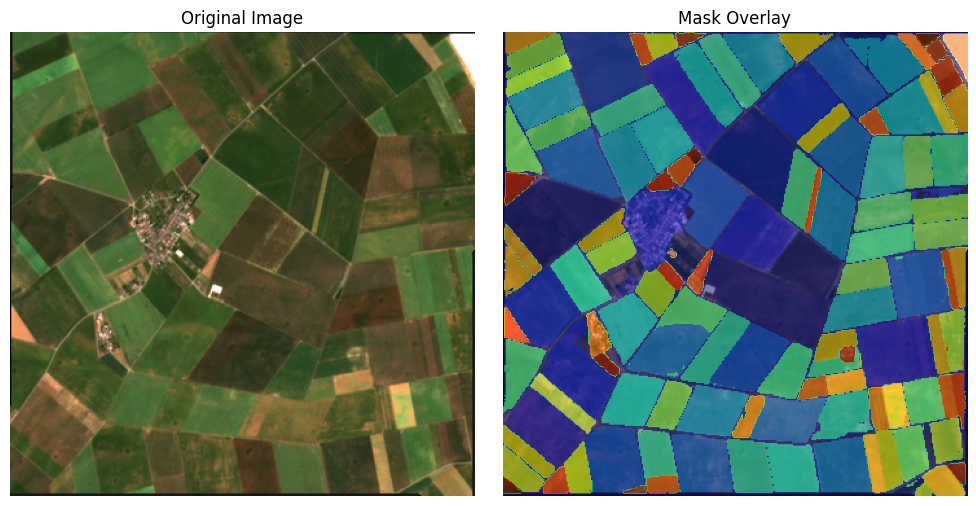

In [32]:
rgb_img = tiff.imread(list_downloaded_imgs[0])
msk_img = tiff.imread(sam_output_tif_path)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(rgb_img.astype("uint8"))
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(rgb_img.astype("uint8"))
plt.imshow(msk_img.astype("uint8"), cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Mask Overlay')
plt.tight_layout()
plt.show()


#### Polygonize segmentation mask

In [33]:
shapefile_path = os.path.join(segmentation_output_path,"auto_mask.shp")
raster_to_shapefile(sam_output_tif_path, shapefile_path)

Text(79.6722222222222, 0.5, 'Latitude')

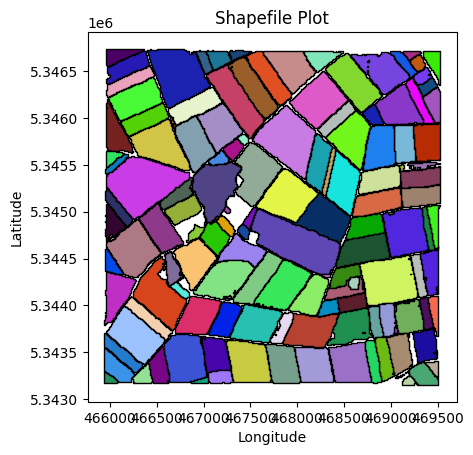

In [34]:
gdf = gpd.read_file(shapefile_path)
num_polygons = len(gdf)
colors = ['#{:06x}'.format(np.random.randint(0, 256**3)) for _ in range(num_polygons)]
gdf.plot(color=colors, edgecolor='black')
plt.title('Shapefile Plot')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

#### Filter polygons with surface less that 100000

Text(78.63692810457515, 0.5, 'Latitude')

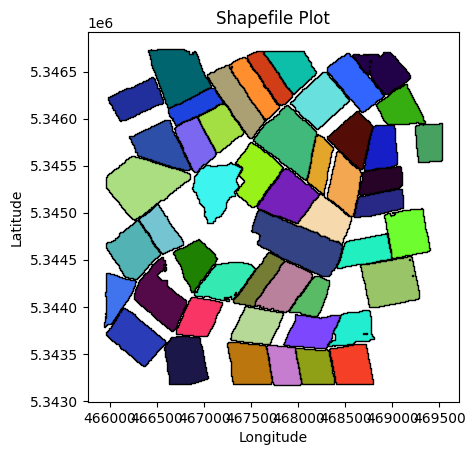

In [35]:
threshold_area = 100000.0  
gdf['area'] = gdf.geometry.area
gdf_filtered = gdf[gdf['area'] > threshold_area]
gdf_filtered = gdf_filtered.drop(columns=['area'])
num_polygons = len(gdf_filtered)
colors = ['#{:06x}'.format(np.random.randint(0, 256**3)) for _ in range(num_polygons)]
gdf_filtered.plot(color=colors, edgecolor='black')
plt.title('Shapefile Plot')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [36]:
gdf_filtered.to_file(os.path.join(segmentation_output_path,"filtered_mask.shp"))

In [43]:
fields_gdf = gpd.read_file(os.path.join(segmentation_output_path,"filtered_mask.shp"))
fields_gdf['geometry'] = fields_gdf.geometry.simplify(tolerance=10, preserve_topology=True)
fields_gdf = fields_gdf.to_crs("EPSG:4326")

In [44]:
center_lat = fields_gdf.geometry.centroid.y.mean()
center_lon = fields_gdf.geometry.centroid.x.mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=13)
folium.TileLayer('openstreetmap').add_to(m)
folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(m)
def add_polygon_to_map(polygon, map_obj):
    folium.GeoJson(polygon).add_to(map_obj)
for _, row in fields_gdf.iterrows():
    add_polygon_to_map(row['geometry'], m)
folium.LayerControl().add_to(m)
m

/var/folders/j3/513qxyhx4l30byl48tz1k1jr0000gn/T/ipykernel_31046/3828052536.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lat = fields_gdf.geometry.centroid.y.mean()
/var/folders/j3/513qxyhx4l30byl48tz1k1jr0000gn/T/ipykernel_31046/3828052536.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lon = fields_gdf.geometry.centroid.x.mean()


#### Select randomly three fields from the filtered GeoDataFrame

Text(133.13343274568425, 0.5, 'Latitude')

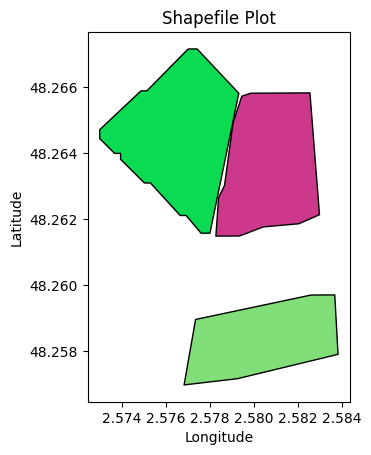

In [45]:
random_rows = fields_gdf.sample(n=3, random_state=7)
colors = ['#{:06x}'.format(np.random.randint(0, 256**3)) for _ in range(len(random_rows))]
random_rows.plot(color=colors, edgecolor='black')
plt.title('Shapefile Plot')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

#### For each polygon (field), send a POST request to Sentinel API to get NDVI in 2023 with 10% cloud cover

In [46]:
list_tasks = []
for idx, row in random_rows.iterrows():
    coords = geometry_to_coords(row['geometry'])
    data = {
    "geometry":coords,
    "start_date":"2023-01-01",
    "end_date":"2023-12-31",
    "cloud_cover":"10",
    "index":"NDVI"  
    }
    response = requests.post(os.path.join(sentinel_api,"api/v1/s2l2a/roi/process"), headers=headers, json=data)
    print(response.text)
    task_id = json.loads(response.content.decode())
    list_tasks.append(task_id["task_id"])   

{"task_id":"37b87a31-ae9a-47d1-87d8-52f48a3eeb35"}
{"task_id":"47729b51-7d17-4b22-b49b-26bd7842465b"}
{"task_id":"6fd0f897-876c-419e-a08a-c2268a9b4387"}


#### Monitor tasks status

In [47]:
for idx, task_id in enumerate(list_tasks):
    print (idx)
    params = {'task_id': task_id}
    response = requests.get(os.path.join(sentinel_api,"api/v1/task/status"), headers=headers, params=params)
    print(response.text)

0
{"task_id":"37b87a31-ae9a-47d1-87d8-52f48a3eeb35","state":"SUCCESS","result":"[{'image': 'L2/tiles/31/U/DP/S2B_MSIL2A_20231007T104829_N0509_R051_T31UDP_20231007T135731.SAFE', 'processed': True, 'url': 'https://object-store.os-api.cci1.ecmwf.int/MoBucket/37b87a31-ae9a-47d1-87d8-52f48a3eeb35/T31UDP_20231007T104829_NDVI.tif?AWSAccessKeyId=e850aff0dd5749a0a8df9f909014049c&Signature=%2BsQaIRp30igB07Pz586ej%2Fjkh4U%3D&Expires=1719429245', 'uri': 's3://MoBucket/37b87a31-ae9a-47d1-87d8-52f48a3eeb35/T31UDP_20231007T104829_NDVI.tif'}, {'image': 'L2/tiles/31/U/DP/S2A_MSIL2A_20230604T104621_N0509_R051_T31UDP_20230604T165401.SAFE', 'processed': True, 'url': 'https://object-store.os-api.cci1.ecmwf.int/MoBucket/37b87a31-ae9a-47d1-87d8-52f48a3eeb35/T31UDP_20230604T104621_NDVI.tif?AWSAccessKeyId=e850aff0dd5749a0a8df9f909014049c&Signature=qkP1OUAfxwkeJrGvf%2B55ubMAwr4%3D&Expires=1719429253', 'uri': 's3://MoBucket/37b87a31-ae9a-47d1-87d8-52f48a3eeb35/T31UDP_20230604T104621_NDVI.tif'}, {'image': 'L2/til

#### Save results to local files

In [48]:
for task_id in list_tasks:
    params = {'task_id': task_id}
    response = requests.get(os.path.join(sentinel_api,"api/v1/s2l2a/roi/process"), headers=headers, params=params)
    results = response.json()
    task_output_path = os.path.join(data_path,"NDVI",task_id)
    os.makedirs(task_output_path,exist_ok=True)
    for res in results["results"]:
        file_name = get_filename_from_url(res["url"])
        res_output_path = os.path.join(task_output_path,file_name)
        save_image_from_url(res["url"],res_output_path)

Image successfully saved to data/crop_monitoring/NDVI/37b87a31-ae9a-47d1-87d8-52f48a3eeb35/T31UDP_20231007T104829_NDVI.tif
Image successfully saved to data/crop_monitoring/NDVI/37b87a31-ae9a-47d1-87d8-52f48a3eeb35/T31UDP_20230604T104621_NDVI.tif
Image successfully saved to data/crop_monitoring/NDVI/37b87a31-ae9a-47d1-87d8-52f48a3eeb35/T31UDP_20230907T104629_NDVI.tif
Image successfully saved to data/crop_monitoring/NDVI/37b87a31-ae9a-47d1-87d8-52f48a3eeb35/T31UDP_20230614T105031_NDVI.tif
Image successfully saved to data/crop_monitoring/NDVI/37b87a31-ae9a-47d1-87d8-52f48a3eeb35/T31UDP_20230525T105031_NDVI.tif
Image successfully saved to data/crop_monitoring/NDVI/37b87a31-ae9a-47d1-87d8-52f48a3eeb35/T31UDP_20230214T105141_NDVI.tif
Image successfully saved to data/crop_monitoring/NDVI/47729b51-7d17-4b22-b49b-26bd7842465b/T31UDP_20230214T105141_NDVI.tif
Image successfully saved to data/crop_monitoring/NDVI/47729b51-7d17-4b22-b49b-26bd7842465b/T31UDP_20230614T105031_NDVI.tif
Image successful

#### Visualize NDVI Maps to monitor crops

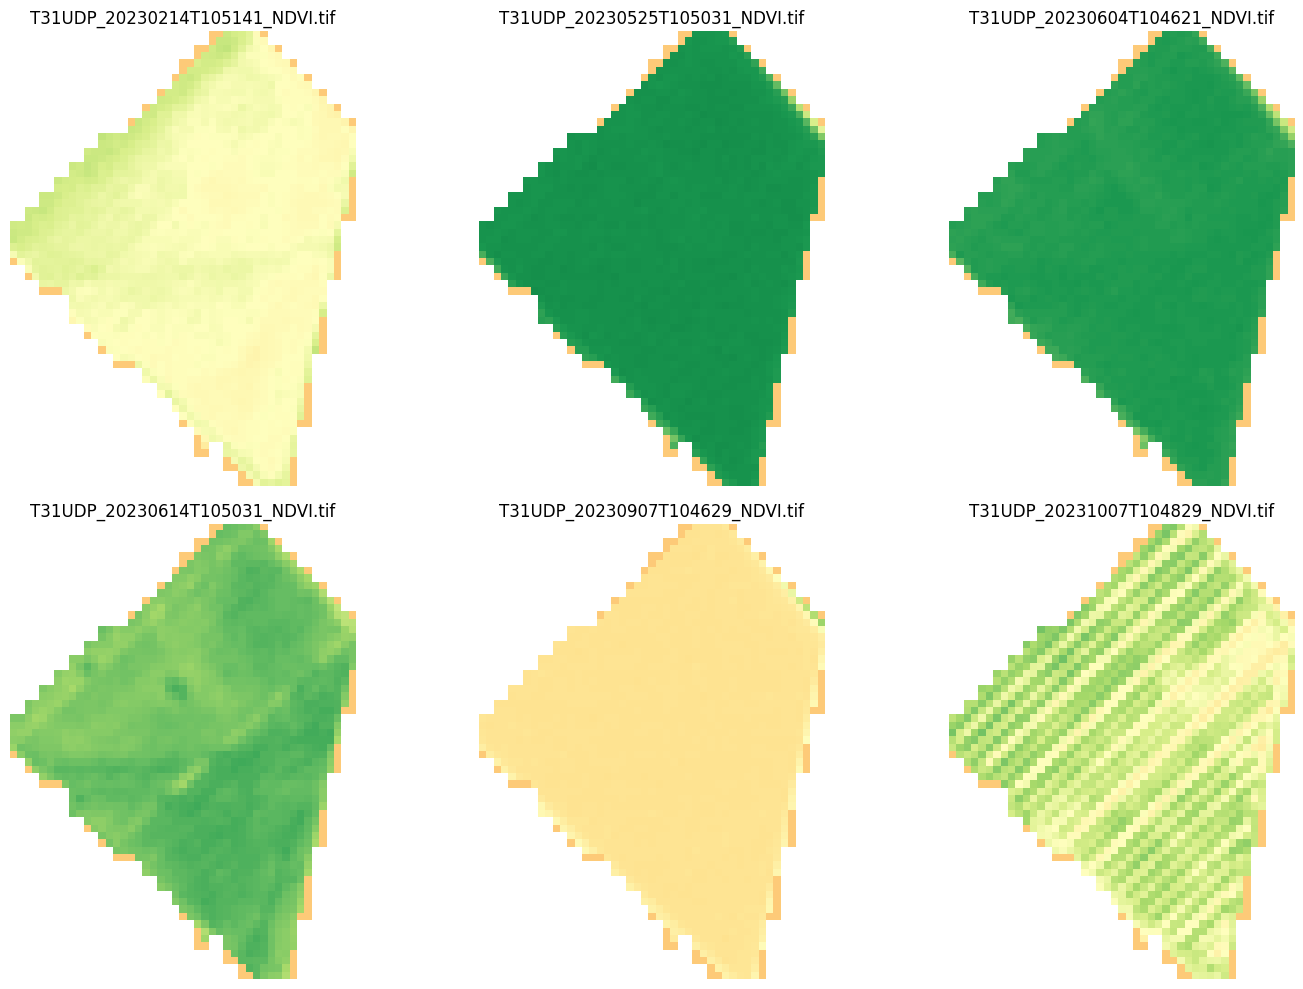

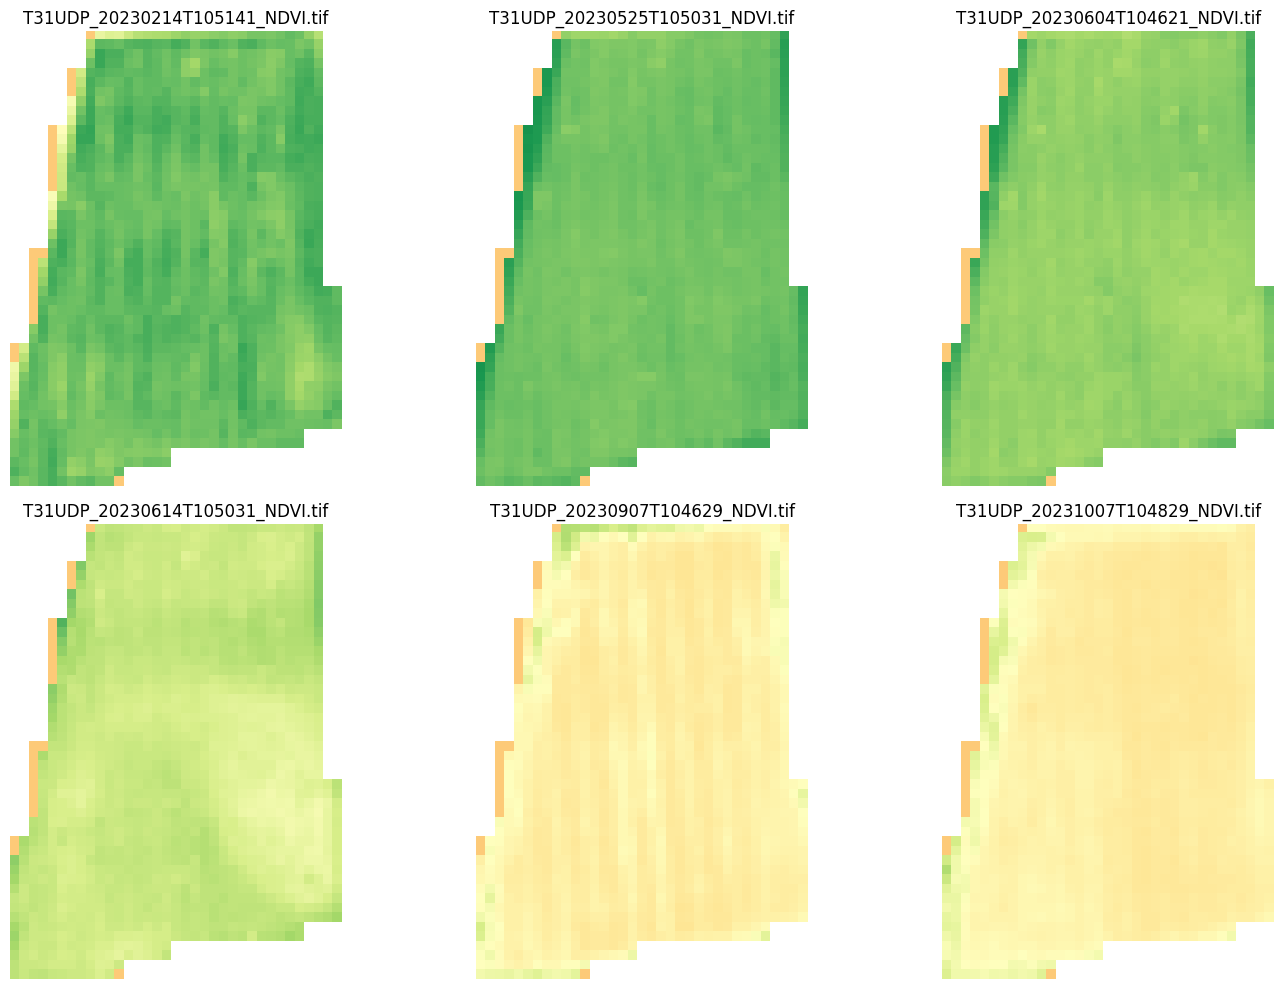

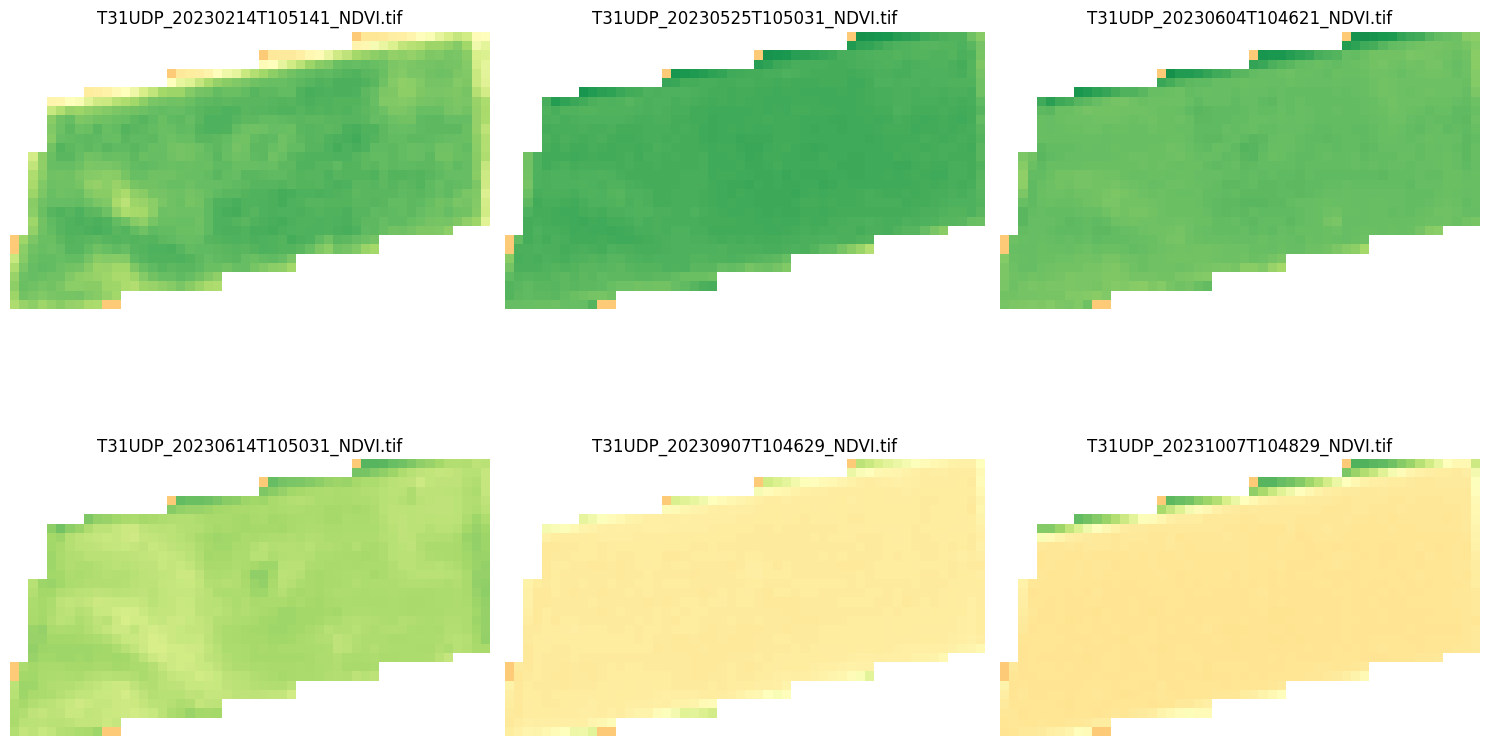

In [49]:
ndvi_path = os.path.join(data_path,"NDVI")
for task_example in list_tasks:
    list_downloaded_imgs = [os.path.join(ndvi_path,task_example,name) for name in os.listdir(os.path.join(ndvi_path,task_example))\
                            if os.path.isfile(os.path.join(ndvi_path,task_example,name))\
                                and name.split(".")[1]=="tif" and len(name.split("."))==2]
    list_downloaded_imgs = sorted(list_downloaded_imgs,\
                                key=lambda x: int(os.path.basename(x).split("_")[1][0:8]))
    num_images = len(list_downloaded_imgs)
    cols = 3  
    rows = (num_images // cols) + (num_images % cols > 0) 
    plt.figure(figsize=(15, 5 * rows)) 
    for i, image_path in enumerate(list_downloaded_imgs):
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue
        img = tiff.imread(image_path)
        img[img==-1000] = np.nan
        plt.subplot(rows, cols, i + 1)
        cmap = plt.get_cmap('RdYlGn')
        norm = mcolors.TwoSlopeNorm(vmin=-1, vcenter=0.4, vmax=1)
        plt.imshow(img, cmap=cmap, norm=norm)
        #plt.imshow(img)
        plt.axis('off') 
        plt.title(os.path.basename(image_path))
    plt.tight_layout()
    plt.show()

### WORKFLOW 2 Leaf Area Index Estimation

#### Send a request to the Sentinel API to prepare a tile with stack of bands

In [50]:
data = {
    "tile":"31UDP",
    "start_date":"2023-06-01",
    "end_date":"2023-09-01",
    "cloud_cover":"10",
    "index":"['B02','B03','B04','B05','B06','B07','B08','B8A','B11','B12']"  
}
response = requests.post(os.path.join(sentinel_api,"api/v1/s2l2a/tile/process"), headers=headers, json=data)
print(response.text)
task_id = json.loads(response.content.decode())

{"task_id":"a736fedb-b109-427b-983f-243a8d692ef3"}


#### Monitor task status

In [51]:
params = {'task_id': task_id["task_id"]}
response = requests.get(os.path.join(sentinel_api,"api/v1/task/status"), headers=headers, params=params)
print(response.text)

{"task_id":"a736fedb-b109-427b-983f-243a8d692ef3","state":"SUCCESS","result":"[{'image': 'L2/tiles/31/U/DP/S2B_MSIL2A_20230821T105629_N0509_R094_T31UDP_20230821T140250.SAFE', 'processed': True, 'url': 'https://object-store.os-api.cci1.ecmwf.int/MoBucket/a736fedb-b109-427b-983f-243a8d692ef3/T31UDP_20230821T105629_stack.tif?AWSAccessKeyId=e850aff0dd5749a0a8df9f909014049c&Signature=To5xwtqbo%2BdLRuqZ350i7GU6tjQ%3D&Expires=1719429593', 'uri': 's3://MoBucket/a736fedb-b109-427b-983f-243a8d692ef3/T31UDP_20230821T105629_stack.tif'}, {'image': 'L2/tiles/31/U/DP/S2A_MSIL2A_20230607T105621_N0509_R094_T31UDP_20230607T171312.SAFE', 'processed': True, 'url': 'https://object-store.os-api.cci1.ecmwf.int/MoBucket/a736fedb-b109-427b-983f-243a8d692ef3/T31UDP_20230607T105621_stack.tif?AWSAccessKeyId=e850aff0dd5749a0a8df9f909014049c&Signature=MP4AQ5tdN2fn7MJ3xPPJrLVXYL8%3D&Expires=1719429756', 'uri': 's3://MoBucket/a736fedb-b109-427b-983f-243a8d692ef3/T31UDP_20230607T105621_stack.tif'}, {'image': 'L2/tiles

#### Get results

In [52]:
params = {'task_id': task_id["task_id"]}
response = requests.get(os.path.join(sentinel_api,"api/v1/s2l2a/tile/process"), headers=headers, params=params)
results = response.json()
print (results)
print (len(results['results']))

{'results': [{'image': 'L2/tiles/31/U/DP/S2B_MSIL2A_20230821T105629_N0509_R094_T31UDP_20230821T140250.SAFE', 'processed': True, 'url': 'https://object-store.os-api.cci1.ecmwf.int/MoBucket/a736fedb-b109-427b-983f-243a8d692ef3/T31UDP_20230821T105629_stack.tif?AWSAccessKeyId=e850aff0dd5749a0a8df9f909014049c&Signature=To5xwtqbo%2BdLRuqZ350i7GU6tjQ%3D&Expires=1719429593', 'uri': 's3://MoBucket/a736fedb-b109-427b-983f-243a8d692ef3/T31UDP_20230821T105629_stack.tif'}, {'image': 'L2/tiles/31/U/DP/S2A_MSIL2A_20230607T105621_N0509_R094_T31UDP_20230607T171312.SAFE', 'processed': True, 'url': 'https://object-store.os-api.cci1.ecmwf.int/MoBucket/a736fedb-b109-427b-983f-243a8d692ef3/T31UDP_20230607T105621_stack.tif?AWSAccessKeyId=e850aff0dd5749a0a8df9f909014049c&Signature=MP4AQ5tdN2fn7MJ3xPPJrLVXYL8%3D&Expires=1719429756', 'uri': 's3://MoBucket/a736fedb-b109-427b-983f-243a8d692ef3/T31UDP_20230607T105621_stack.tif'}, {'image': 'L2/tiles/31/U/DP/S2A_MSIL2A_20230614T105031_N0509_R051_T31UDP_20230614T163

In [53]:
lai_output_path = os.path.join(data_path,"lai")
os.makedirs(lai_output_path,exist_ok=True)

#### Send a POST request to the LAI API

In [54]:
data = {"list_image_uri":[results["results"][1]["uri"]]}
response = requests.post(os.path.join(lai_api,"api/v1/lai/process"),headers=headers,json=data)
print (response.text)
task_id = json.loads(response.content.decode())

{"task_id":"f42fb4d0-ccc7-4ac2-8b36-2273c46228ad"}


#### Check status of the submitted task

In [55]:
params = {'task_id': task_id["task_id"]}
response = requests.get(os.path.join(lai_api,"api/v1/task/status"), headers=headers, params=params)
print(response.text)

{"task_id":"f42fb4d0-ccc7-4ac2-8b36-2273c46228ad","state":"SUCCESS","result":"[{'image_uri': 's3://MoBucket/a736fedb-b109-427b-983f-243a8d692ef3/T31UDP_20230607T105621_stack.tif', 'processed': True, 'result_url': 'https://object-store.os-api.cci1.ecmwf.int/MoBucket/f42fb4d0-ccc7-4ac2-8b36-2273c46228ad/T31UDP_20230607T105621_stack_LAI.tif?AWSAccessKeyId=e850aff0dd5749a0a8df9f909014049c&Signature=BjTVk2%2BO7oUY5LKtunwl3HzNDfs%3D&Expires=1719430453', 'result_uri': 's3://MoBucket/f42fb4d0-ccc7-4ac2-8b36-2273c46228ad/T31UDP_20230607T105621_stack_LAI.tif'}]"}


#### Get processing results

In [56]:
params = {'task_id': task_id["task_id"]}
response = requests.get(os.path.join(lai_api,"api/v1/lai/process"), headers=headers, params=params)
results = response.json()
print (results)

{'results': [{'image_uri': 's3://MoBucket/a736fedb-b109-427b-983f-243a8d692ef3/T31UDP_20230607T105621_stack.tif', 'processed': True, 'result_url': 'https://object-store.os-api.cci1.ecmwf.int/MoBucket/f42fb4d0-ccc7-4ac2-8b36-2273c46228ad/T31UDP_20230607T105621_stack_LAI.tif?AWSAccessKeyId=e850aff0dd5749a0a8df9f909014049c&Signature=BjTVk2%2BO7oUY5LKtunwl3HzNDfs%3D&Expires=1719430453', 'result_uri': 's3://MoBucket/f42fb4d0-ccc7-4ac2-8b36-2273c46228ad/T31UDP_20230607T105621_stack_LAI.tif'}]}


#### Save results to local file

In [57]:
file_name = get_filename_from_url(results["results"][0]["result_url"])
lai_output_tif_path = os.path.join(lai_output_path,file_name)
save_image_from_url(results["results"][0]["result_url"],lai_output_tif_path)

Image successfully saved to data/crop_monitoring/lai/T31UDP_20230607T105621_stack_LAI.tif


#### Visualize LAI results

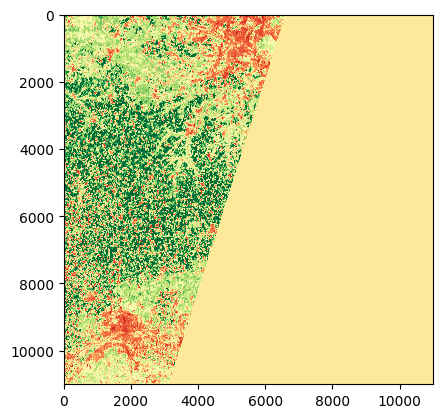

In [58]:
lai_arr = tiff.imread(lai_output_tif_path)
cmap = plt.get_cmap('RdYlGn')
norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=2.0, vmax=5)
plt.imshow(lai_arr, cmap=cmap, norm=norm)